# Quantum walk on 2D hypercycle

In [2]:
import qiskit as qk

# target machine
sim = qk.Aer.get_backend('qasm_simulator')

# numer of qubits for each cordinate
# size of the walk in qubits in qdim+qdim
qdim = 5

# number of steps
steps = 2**(qdim-1)

# numer of simulations
shots = 100

print('Number of qubits:', qdim+qdim)
print('Number of steps:', steps)
print('Number of simulations:', shots)

Number of qubits: 10
Number of steps: 16
Number of simulations: 100


## Operators used in arXiv:0706.0304

In [3]:
def increment(qc, qr, dim):
    for i in range(dim):
        qc.mct(qr[0:dim - i], qr[dim - i], None, mode='noancilla')
        
def decrement(qc, qr, dim):
    for i in range(dim):
        qc.x(qr[0:dim - i])
        qc.mct(qr[0:dim - i], qr[dim - i], None, mode='noancilla')
        qc.x(qr[0:dim - i])

## Allocate registers

In [4]:
# allocate main registers using (x,y) coordinats
# for choosing the directions
x_qcoin = qk.QuantumRegister(1, name='c-x')
y_qcoin = qk.QuantumRegister(1, name='c-y')

# for encoding direction in one qubit
xy_qcoin = qk.QuantumRegister(1, name='c-xy')

x_qr = qk.QuantumRegister(qdim, name='q-x')
y_qr = qk.QuantumRegister(qdim, name='q-y')

x_cr = qk.ClassicalRegister(qdim, name='x')
y_cr = qk.ClassicalRegister(qdim, name='y')

qc = qk.QuantumCircuit()

# add registers to the circuit
qc.add_register(x_qcoin)
qc.add_register(y_qcoin)
qc.add_register(xy_qcoin)

qc.add_register(x_qr)
qc.add_register(y_qr)

qc.add_register(x_cr)
qc.add_register(y_cr)

## Initialize the coin

In [5]:
# initial state of the coins
qc.h(x_qcoin)
qc.s(x_qcoin)

qc.h(y_qcoin)
qc.s(y_qcoin)

qc.barrier()

## Check on which qubits we need to act

In [6]:
[qc.qubits[2]] + qc.qubits[3:3+qdim]

[Qubit(QuantumRegister(1, 'c-xy'), 0),
 Qubit(QuantumRegister(5, 'q-x'), 0),
 Qubit(QuantumRegister(5, 'q-x'), 1),
 Qubit(QuantumRegister(5, 'q-x'), 2),
 Qubit(QuantumRegister(5, 'q-x'), 3),
 Qubit(QuantumRegister(5, 'q-x'), 4)]

In [7]:
[qc.qubits[2]] + qc.qubits[3+qdim:3+qdim+qdim]

[Qubit(QuantumRegister(1, 'c-xy'), 0),
 Qubit(QuantumRegister(5, 'q-y'), 0),
 Qubit(QuantumRegister(5, 'q-y'), 1),
 Qubit(QuantumRegister(5, 'q-y'), 2),
 Qubit(QuantumRegister(5, 'q-y'), 3),
 Qubit(QuantumRegister(5, 'q-y'), 4)]

## Main loop

In [8]:
# quantum circuit implementing a quantum walk along a 2D hypercycle from arXiv:0706.0304

# chose on which qubits to act during each step
x_qubits = [qc.qubits[2]] + qc.qubits[3:3+qdim]
y_qubits = [qc.qubits[2]] + qc.qubits[3+qdim:3+qdim+qdim]

for _ in range(steps):
    qc.h(x_qcoin)
    qc.h(y_qcoin)
    
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    increment(qc, x_qubits, qdim)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
  
    qc.x(x_qcoin)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    decrement(qc, x_qubits, qdim)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    qc.x(x_qcoin)
    
    qc.x(y_qcoin)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    increment(qc, y_qubits, qdim)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    qc.x(y_qcoin)
    
    qc.x(y_qcoin)
    qc.x(x_qcoin)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    decrement(qc, y_qubits, qdim)
    qc.ccx(x_qcoin,y_qcoin, xy_qcoin)
    qc.x(x_qcoin)
    qc.x(y_qcoin)
    
#     qc.barrier()

## Final measurement

In [9]:
# ignore the coin (qc.qubits[0]) register
qc.measure(x_qr, x_cr);
# qc.barrier()
qc.measure(y_qr, y_cr);

In [10]:
# makes sense only for small circuits
# qc.draw(output='mpl')

In [11]:
# NOTE: results of y_qr measurement 
job = qk.execute(qc, sim, shots=shots)
counts = job.result().get_counts(qc)

In [12]:
# counts

# qk.visualization.plot_histogram(counts)

## Convert to matrix form for some visualization

In [13]:
data = np.zeros((2**qdim,2**qdim))

for k in counts.keys():
    [i,j] = map(lambda x:int(x,2), k.split(' '))
    data[i,j] = counts[k]/shots

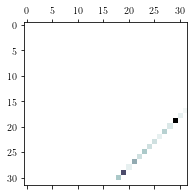

In [20]:
from IPython.core.display import display

import numpy as np
import matplotlib as mpl

mpl.rc('text', usetex = True)
mpl.rc('font', size = 10)

fig = mpl.figure.Figure(figsize=(3,3))
axs = fig.add_subplot()
axs.matshow(data, cmap=plt.cm.bone.reversed())
display(fig)

In [21]:
fig.savefig("quantum-walk-2D-hypercycle.pdf")